https://github.com/speechbrain/speechbrain/tree/develop/recipes/VoxCeleb/SpeakerRec#speaker-verification-using-ecapa-tdnn-embeddings

## Libraries

In [2]:
import os
import time
from speechbrain.inference.speaker import SpeakerRecognition
from speechbrain.inference.encoders import MelSpectrogramEncoder
import torchaudio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from tqdm import tqdm

FRENCH = True


C:\Users\echriston\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
torchvision is not available - cannot save figures


## Global variables

In [3]:
input_model_dir = "../../../data/pretrained_models/"
models_to_test = ["spkrec-ecapa-voxceleb", "spkrec-xvect-voxceleb"] # ["spkrec-ecapa-voxceleb", "spkrec-xvect-voxceleb", "spkrec-resnet-voxceleb"]
model_colors = {"spkrec-ecapa-voxceleb": ("#2265BD", "Blues"), "spkrec-xvect-voxceleb": ("orange", "Oranges"), "spkrec-resnet-voxceleb": ("#63A93A", "Greens")}

people_folder = "../../../data/stored/people/"
base_people_audios = dict()
for person in [f for f in os.listdir(people_folder) if not f.endswith('.md')]:
    if person == "Unknown":
        continue
    audio_file = [f for f in os.listdir(people_folder + person + "/voices/") if f.endswith('_16000.wav')][0]
    base_people_audios[person] = person + "/voices/" + audio_file

print(base_people_audios)

audios_to_verify_folder = "audios_to_test/"
# contains folders with audios to test folder name being the person name
audios_to_verify = dict()
for person in [f for f in os.listdir(audios_to_verify_folder) if not '.' in f]:
    audios_to_verify[person] = []
    for audio in [f for f in os.listdir(audios_to_verify_folder + person) if (f.endswith('_16000.wav'))]:
        audios_to_verify[person].append(person + "/" + audio)
print(audios_to_verify)

{'alex_pereira_ferreira': 'alex_pereira_ferreira/voices/alex_pereira_ferreira_16000.wav', 'beatriz_rojas_romero': 'beatriz_rojas_romero/voices/beatriz_rojas_romero_16000.wav', 'benoit_froge': 'benoit_froge/voices/benoit_froge_16000.wav', 'clement_lidar': 'clement_lidar/voices/clement_lidar_16000.wav', 'eliot_christon': 'eliot_christon/voices/eliot_christon_16000.wav', 'florent_bissonnier': 'florent_bissonnier/voices/florent_bissonnier_16000.wav', 'hadrien_genuer': 'hadrien_genuer/voices/hadrien_genuer_16000.wav', 'ines_delplanque': 'ines_delplanque/voices/ines_delplanque_16000.wav', 'ingrid_floriet': 'ingrid_floriet/voices/ingrid_floriet_16000.wav', 'nahel_verdier': 'nahel_verdier/voices/nahel_verdier_16000.wav', 'neill_vanmoc': 'neill_vanmoc/voices/neill_vanmoc_16000.wav', 'raphael_maarek': 'raphael_maarek/voices/raphael_maarek_16000.wav', 'tatyana_budueva': 'tatyana_budueva/voices/tatyana_budueva_16000.wav', 'thomas_oxisoglou': 'thomas_oxisoglou/voices/thomas_oxisoglou_16000.wav'}
{'

In [4]:
def plot_matrix(confusion_matrix, model, labels, colormap=None, N=0):

    if colormap is None:
        colormap = plt.cm.get_cmap('viridis')

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(confusion_matrix, cmap=colormap)

    max_val = confusion_matrix.max()
    min_val = confusion_matrix.min()
    for i in range(len(labels)):
        for j in range(len(labels)):
            value = confusion_matrix[i, j]
            if value == N:
                continue
            bg_color = colormap((value - min_val) / (max_val - min_val))
            lum = 0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2]
            text_color = 'black' if lum > 0.5 else 'white'
            ax.text(j, i, value, ha='center', va='center', color=text_color, fontsize=16)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels)
    ax.grid(alpha = 0.3)

    model_str = model.replace("spkrec-", "").replace("-voxceleb", "")
    
    if FRENCH:
        ax.set_xlabel('Prédit')
        ax.set_ylabel('Réel')
        ax.set_title(f"Matrice de confusion pour le modèle {model_str}\n", fontsize=18)
    else:
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Ground truth')
        ax.set_title(f"Confusion matrix for model {model_str}\n", fontsize=18)

    plt.tight_layout()
    plt.savefig(f"plots/confusion_matrix_{model}.png")
    plt.show()


## Build Dataframes

### Results

In [ ]:
results_df = pd.DataFrame(columns=["model", "audio_to_verify", "audio_reference", "name_to_verify", "name_reference", "result", "proba", "time"])


for model_name in models_to_test:
    print(f"\n===================================\n### MODEL {model_name.upper()}\n")

    speaker_recognition = SpeakerRecognition.from_hparams(source=f"speechbrain/{model_name}", savedir=input_model_dir + model_name)

    for name_to_verify, audios_t_v in audios_to_verify.items():
        for audio_to_verify in audios_t_v:
            print(f"\nAUDIO TO VERIFY: {audio_to_verify}")
            audio_to_verify_path = os.path.join(audios_to_verify_folder, audio_to_verify)

            for name_reference, audio_reference in base_people_audios.items():
                print(f" - REFERENCE AUDIO: {audio_reference}")
                audio_ref_path = os.path.join(people_folder, audio_reference)
                
                # Speaker verification
                start = time.time()
                proba, result = speaker_recognition.verify_files(audio_to_verify_path, audio_ref_path)
                end = time.time()
                print(f"    * Speaker verification result: {result.item()} ({proba.item()})")
                print(f"    * Time: {end - start}")
                
                raw = [model_name, audio_to_verify, audio_reference, name_to_verify, name_reference, result.item(), proba.item(), end - start]
                new_df = pd.DataFrame([raw], columns=results_df.columns)
                if len(results_df) == 0:
                    results_df = new_df
                else:
                    results_df = pd.concat([results_df, new_df], ignore_index=True)

results_df.to_csv("results.csv", index=False)

### Creating Embeddings

In [4]:
embedding_df = pd.DataFrame(columns=["model", "audio", "name", "embedding", "time"])

big_list = [(name, audio, people_folder) for name, audio in base_people_audios.items()] + [(name, audio, audios_to_verify_folder) for name, audios in audios_to_verify.items() for audio in audios]

model_name = "spkrec-ecapa-voxceleb-mel-spec"

encoder = MelSpectrogramEncoder.from_hparams(source=f"speechbrain/{model_name}", savedir=input_model_dir + model_name)

# create embeddings for reference audios
for name, audio, folder in tqdm(big_list):
    # print(f"\nAUDIO: {audio}")
    audio_path = os.path.join(folder, audio)
    
    # Speaker embedding
    try:
        start = time.time()
        audio_tensor, sr = torchaudio.load(audio_path)
        # print(f"    * Sample rate: {sr}")
        # print(f"    * Audio tensor shape: {audio_tensor.shape}")
        # if stereo, convert to mono
        if audio_tensor.shape[0] == 2:
            audio_tensor = audio_tensor.mean(dim=0, keepdim=True)
        embedding = encoder.encode_waveform(audio_tensor)
        embedding = embedding.detach().numpy()
        end = time.time()
        # print(f"    * Time: {end - start}")
    except Exception as e:
        print(f"Error with audio {audio_path}: {e}")
        print(f"    * Sample rate: {sr}")
        print(f"    * Audio tensor shape: {audio_tensor.shape}")
        continue

    raw = [model_name, audio, name, embedding, end - start]

    new_df = pd.DataFrame([raw], columns=embedding_df.columns)
    if len(embedding_df) == 0:
        embedding_df = new_df
    else:
        embedding_df = pd.concat([embedding_df, new_df], ignore_index=True)
    
embedding_df.to_csv("embeddings.csv", index=False)
        

100%|██████████| 1323/1323 [01:31<00:00, 14.39it/s]


### audio_duration_df scanning all audio files

In [ ]:
# build a df of audio durations
audio_durations = pd.DataFrame(columns=["audio", "duration"])

def get_audio_duration(filepath):
    print(f" - AUDIO: {filepath}")
    sf_info = sf.info(filepath)
    frames = sf_info.frames
    rate = sf_info.samplerate    
    return frames / float(rate)
    
for audio_name in list(base_people_audios.values()) + [audio for audios in audios_to_verify.values() for audio in audios]:
    audio_path = os.path.join(people_folder, audio_name) if audio_name in base_people_audios.values() else os.path.join(audios_to_verify_folder, audio_name)
    audio_duration = get_audio_duration(audio_path)
    audio_durations = pd.concat([audio_durations, pd.DataFrame([[audio_name, audio_duration]], columns=audio_durations.columns)])

audio_durations.to_csv("audio_durations.csv", index=False)

## Plotting the verification evaluation

In [13]:
# Load the results CSV file
results_df = pd.read_csv("results.csv")


In [14]:
# plot the time taken to verify vs the sum of the durations of the audios
df_plot = results_df.merge(pd.read_csv("audio_durations.csv"), left_on='audio_to_verify', right_on='audio', how='left').rename(columns={'duration': 'duration_to_verify'}).drop(columns='audio')
df_plot = df_plot.merge(pd.read_csv("audio_durations.csv"), left_on='audio_reference', right_on='audio', how='left').rename(columns={'duration': 'duration_reference'}).drop(columns='audio')

# remove from df_plot, all the rows where the df_model['duration_to_verify'] + df_model['duration_reference'] is above 40 seconds
df_plot = df_plot[(df_plot['duration_to_verify'] + df_plot['duration_reference']) < 40]

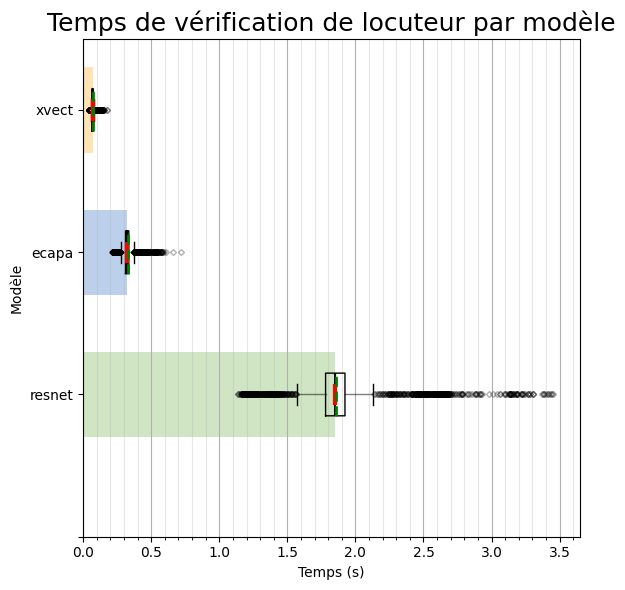

In [15]:

fig, ax = plt.subplots(figsize=(6, 6))  # Adjust figsize as needed

# box plot of transcription time
labels = df_plot['model'].unique().tolist()
# sort the labels by the mean time
labels = [x for _, x in sorted(zip(df_plot.groupby('model')['time'].mean(), labels))]

mytime = [df_plot[df_plot['model'] == model]['time'].values for model in labels]

labels = [''] + labels # Add an empty label to align the bars with the boxplot
y = np.arange(len(labels))

bp = ax.boxplot(mytime, vert=False, notch=True, showmeans=True, meanline=True)

for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
for median in bp['means']:
    median.set(color ='green',
               linewidth = 2)
for whisker in bp['whiskers']:
    whisker.set(alpha = 0.5)
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              markersize = 3,
              color ='#e7298a',
              alpha = 0.3)
# adding bars in the background, from 0 to the median
for i in range(len(labels)-1):
    ax.barh(y[i+1], bp['medians'][i].get_xdata()[0], color=model_colors[labels[i+1]][0], alpha=0.3, height=0.6)
# Add some text for labels, title and custom x-axis tick labels, etc.
if FRENCH:
    ax.set_xlabel('Temps (s)')
    ax.set_ylabel('Modèle')
    ax.set_title('Temps de vérification de locuteur par modèle', fontsize=18)
else:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Model')
    ax.set_title('Speaker verification time par modèle', fontsize=18)
major_ticks = np.arange(0, 10, 0.5)
minor_ticks = np.arange(0, 10, 0.1)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(y)
ylabels = [label.replace("spkrec-", "").replace("-voxceleb", "") for label in labels]
ax.set_yticklabels(ylabels)
ax.grid(axis='x')
ax.set_xlim([0, max([max(t) for t in mytime]) + 0.2])
ax.grid(which='minor', alpha=0.3)
fig.tight_layout()

plt.savefig("plots/verification_time.png")

plt.show()

In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=1)
poly_reg = LinearRegression()

def get_poly_x_y(input_x, input_y):
    X = input_x.reshape(-1, 1)
    y = input_y.copy()
    X_poly = poly.fit_transform(X)
    poly_reg.fit(X_poly, y)
    # new x values
    x_new = np.linspace(X.min()-1, X.max()+1, 100)
    X_new = x_new.reshape(-1, 1)
    X_new_poly = poly.fit_transform(X_new)
    y_new = poly_reg.predict(X_new_poly)

    slope = poly_reg.coef_[1]

    return x_new, y_new, slope


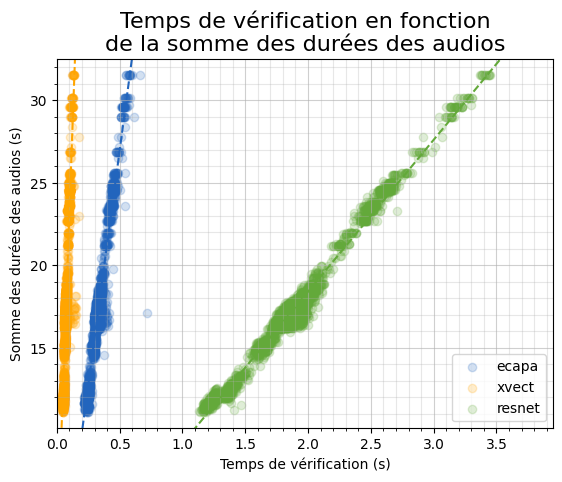

In [17]:

fig, ax = plt.subplots()

for model in df_plot['model'].unique():
    df_model = df_plot[df_plot['model'] == model]
    model_color = model_colors[model][0]
    model_str = model.replace("spkrec-", "").replace("-voxceleb", "")
    ax.scatter(df_model['time'], df_model['duration_to_verify'] + df_model['duration_reference'], label=model_str, alpha=0.2, color=model_color)
    x_new, y_new, slope = get_poly_x_y(df_model['time'].values, df_model['duration_to_verify'] + df_model['duration_reference'])
    ax.plot(x_new, y_new, linestyle='--', color=model_color)
    coords_text = (max(df_model['time']) - (0.1 * max(df_model['time'])), max(df_model['duration_to_verify'] + df_model['duration_reference']) - 10)
    # if FRENCH:
    #     ax.text(*coords_text, f"pente:\n{slope:.2f}", fontsize=11)
    # else:
    #     ax.text(*coords_text, f"slope:\n{slope:.2f}", fontsize=11)
ax.legend()

y_major_ticks = np.arange(0, 101, 5)
y_minor_ticks = np.arange(0, 101, 1)
x_major_ticks = np.arange(0, 11, 0.5)
x_minor_ticks = np.arange(0, 11, 0.1)

ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)
ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)

ax.grid(which='minor', alpha=0.3)
ax.grid(which='major', alpha=0.6)

# limits
ax.set_ylim([min(df_plot['duration_to_verify'] + df_plot['duration_reference']) - 1, max(df_plot['duration_to_verify'] + df_plot['duration_reference']) + 1])
ax.set_xlim([0, max(df_plot['time']) + 0.5])

if FRENCH:
    ax.set_ylabel('Somme des durées des audios (s)')
    ax.set_xlabel('Temps de vérification (s)')
    ax.set_title('Temps de vérification en fonction\nde la somme des durées des audios', fontsize=16)
else:
    ax.set_ylabel('Sum of the durations of the audios (s)')
    ax.set_xlabel('Verification time (s)')
    ax.set_title('Speaker verification time vs\nsum of the durations of the audios', fontsize=16)
plt.savefig("plots/verification_time_vs_duration.png")
plt.show()

                    model       slope
0   spkrec-xvect-voxceleb  209.563311
0   spkrec-ecapa-voxceleb   56.808980
0  spkrec-resnet-voxceleb    9.194791


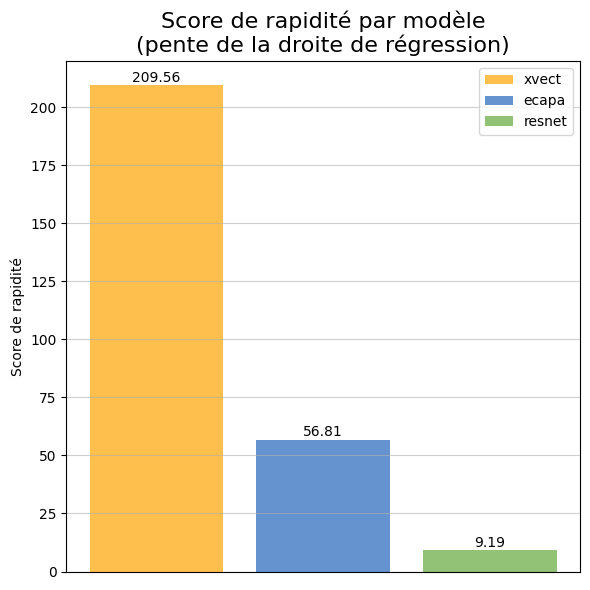

In [18]:
# make the slope a score per model
df_slope = pd.DataFrame(columns=['model', 'slope'])
for model in df_plot['model'].unique():
    df_filtered = df_plot[df_plot['model'] == model]
    _, _, slope = get_poly_x_y(df_filtered['time'].values, df_filtered['duration_to_verify'] + df_filtered['duration_reference'])
    if len(df_slope) == 0:
        df_slope = pd.DataFrame({'model': [model], 'slope': [slope]})
    else:
        df_slope = pd.concat([df_slope, pd.DataFrame({'model': [model], 'slope': [slope]})])

df_slope = df_slope.sort_values(by='slope', ascending=False)
print(df_slope)

# plot the score per model (bar plot)
fig, ax = plt.subplots(figsize=(6, 6))
for i, row in df_slope.iterrows():
    label = row['model'].replace("spkrec-", "").replace("-voxceleb", "")
    ax.bar(row['model'], row['slope'], alpha=0.7, label=label, color=model_colors[row['model']][0])
    ax.text(row['model'], row['slope'] + 0.1, f"{row['slope']:.2f}", ha='center', va='bottom', fontsize=10)

if FRENCH:
    ax.set_ylabel('Score de rapidité')
    ax.set_title('Score de rapidité par modèle\n(pente de la droite de régression)', fontsize=16)
else:
    ax.set_ylabel('Swiftness Score')
    ax.set_title('Swiftness Score per model\n(slope of the regression line)', fontsize=16)
ax.legend()
# no labels on x-axis
plt.xticks([])
plt.grid(axis='y', alpha=0.6)
plt.tight_layout()
plt.savefig("plots/speed_score.png")
plt.show()

In [19]:
# build a df grouping each couple model, audio_to_verify, delete the result, probability and time columns
df_grouped = results_df.drop(columns=['result', 'proba', 'time', 'audio_reference', 'name_reference']).groupby(['model', 'audio_to_verify'])
df_grouped = df_grouped.agg(lambda x: x.value_counts().index[0])
df_grouped = df_grouped.reset_index()
# add an empty column for the prediction
df_grouped['prediction'] = ""
print(df_grouped)

                     model                        audio_to_verify  \
0    spkrec-ecapa-voxceleb     Unknown/eugenie_declaron_short.mp3   
1    spkrec-ecapa-voxceleb          Unknown/example_reference.mp3   
2    spkrec-ecapa-voxceleb  Unknown/jean_pierre_pernaut_short.mp3   
3    spkrec-ecapa-voxceleb  Unknown/out_0_2024-03-20_15-58-14.wav   
4    spkrec-ecapa-voxceleb                 Unknown/out_0_last.wav   
..                     ...                                    ...   
928  spkrec-xvect-voxceleb  thomas_oxisoglou/homme_0_neutre_6.mp3   
929  spkrec-xvect-voxceleb     thomas_oxisoglou/out_0_thomas0.wav   
930  spkrec-xvect-voxceleb     thomas_oxisoglou/out_0_thomas1.wav   
931  spkrec-xvect-voxceleb     thomas_oxisoglou/out_1_thomas0.wav   
932  spkrec-xvect-voxceleb     thomas_oxisoglou/out_1_thomas1.wav   

       name_to_verify prediction  
0             Unknown             
1             Unknown             
2             Unknown             
3             Unknown          

In [20]:
# now let's build the confusion matrix for each model

# for each model
# for each audio to verify
# the prediction is the highest probability of the raws where result is True. if all are False, prediction is "Unknown" (there is already a folder with that name)
# the ground truth is the name_to_verify

people_list = list(base_people_audios.keys()) + ["Unknown"]

confusion_matrices = dict()
for model in results_df['model'].unique():
    confusion_matrices[model] = np.zeros((len(people_list), len(people_list)), dtype=int)

for model in results_df['model'].unique():
    sub_model_df = results_df[results_df['model'] == model]
    for audio_to_verify in sub_model_df['audio_to_verify'].unique():
        sub_audio_df = sub_model_df[sub_model_df['audio_to_verify'] == audio_to_verify]
        prediction = "Unknown"
        if sub_audio_df[['result']].any().item():
            # prediction is the name of the person with the highest probability
            proba_max = sub_audio_df[sub_audio_df['result']]['proba'].max()
            prediction = sub_audio_df[(sub_audio_df['result']) & (sub_audio_df['proba'] == proba_max)]['name_reference'].iloc[0]
        ground_truth = sub_audio_df['name_to_verify'].iloc[0]

        df_grouped.loc[(df_grouped['model'] == model) & (df_grouped['audio_to_verify'] == audio_to_verify), 'prediction'] = prediction

        confusion_matrices[model][people_list.index(ground_truth)][people_list.index(prediction)] += 1

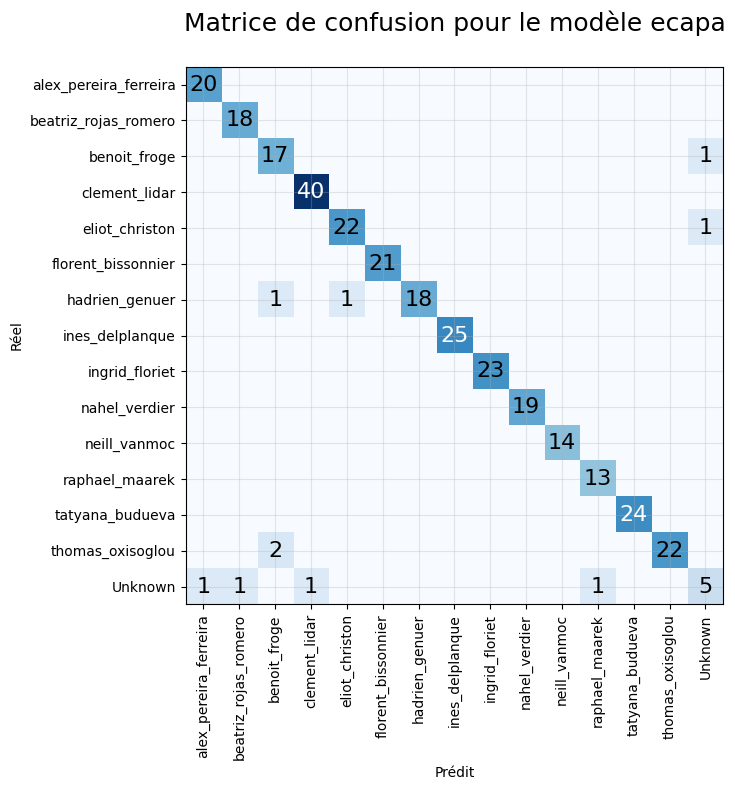

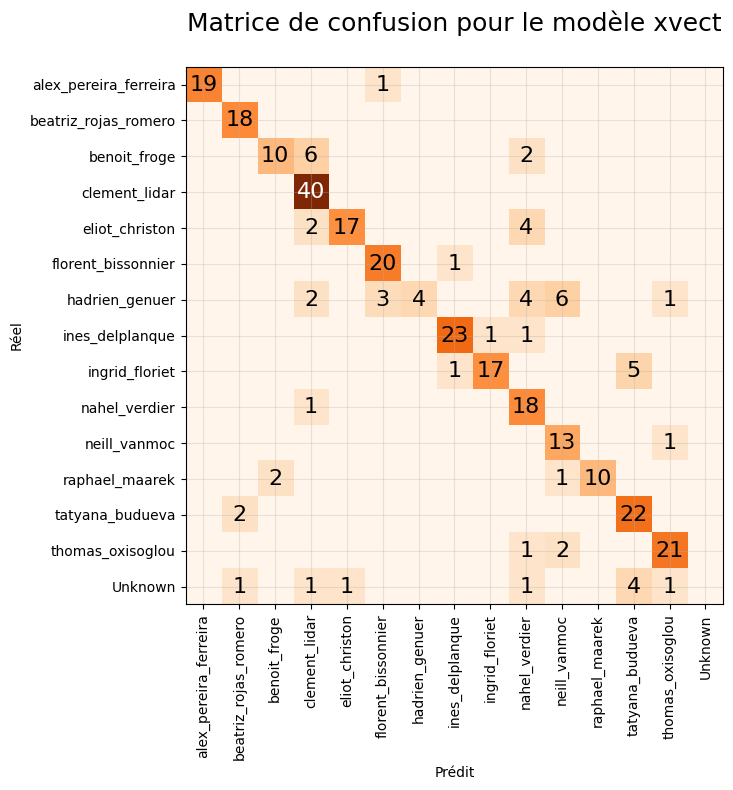

In [21]:
# plot the confusion matrices

minus_confusion_matrices = dict()
N = -5
# replace 0 by N for better visualization
if N != 0:
    for model in confusion_matrices.keys():
        minus_confusion_matrices[model] = confusion_matrices[model].copy()
        minus_confusion_matrices[model][minus_confusion_matrices[model] == 0] = N
else:
    minus_confusion_matrices = confusion_matrices



for i, model in enumerate(models_to_test):

    colormap = plt.colormaps.get(model_colors[model][1])
    labels = people_list
    plot_matrix(minus_confusion_matrices[model], model, labels, colormap=colormap, N=-5)
    

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_all = df_grouped['name_to_verify']
y_pred_all = df_grouped['prediction']

scores_df = pd.DataFrame(columns=["model", "accuracy", "precision", "recall", "f1"])

for model in models_to_test:
    y = df_grouped[df_grouped['model'] == model]['name_to_verify']
    y_pred = df_grouped[df_grouped['model'] == model]['prediction']
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    if len(scores_df) == 0:
        scores_df = pd.DataFrame([[model, accuracy, precision, recall, f1]], columns=scores_df.columns)
    else:
        scores_df = pd.concat([scores_df, pd.DataFrame([[model, accuracy, precision, recall, f1]], columns=scores_df.columns)])

scores_df = scores_df.sort_values(by='f1', ascending=False)
print(scores_df)

                   model  accuracy  precision    recall        f1
0  spkrec-ecapa-voxceleb  0.967846   0.967603  0.967846  0.966831
0  spkrec-xvect-voxceleb  0.810289   0.821477  0.810289  0.786689


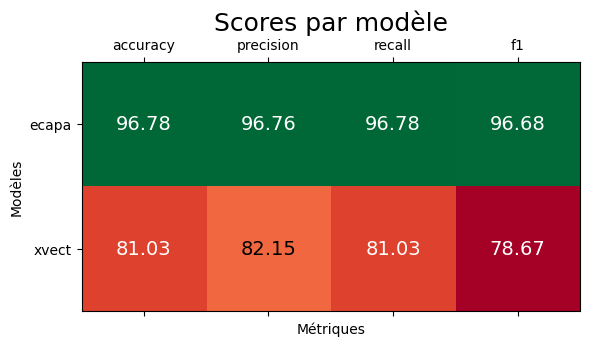

In [23]:
# plot the scores like a matrix, models vs metrics
fig, ax = plt.subplots(figsize=(6, 6))

colormap = plt.colormaps.get('RdYlGn')
# fix the range of the colormap to [0, 1]
colormap.set_over('white', 1)
colormap.set_under('white', 0)

ax.matshow(scores_df.iloc[:, 1:], cmap=colormap)
min_val = scores_df.iloc[:, 1:].min().min()
max_val = scores_df.iloc[:, 1:].max().max()
for i in range(scores_df.shape[0]):
    for j in range(1, scores_df.shape[1]):
        values = scores_df.iloc[i, j]
        bg_color = colormap((values - min_val) / (max_val - min_val))
        lum = 0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2]
        text_color = 'black' if lum > 0.5 else 'white'
        ax.text(j - 1, i, f"{values*100:.2f}", ha='center', va='center', color=text_color, fontsize=14)

ax.set_xticks(range(4))
ax.set_xticklabels(scores_df.columns[1:])
ax.set_yticks(range(scores_df.shape[0]))
ax.set_yticklabels(scores_df['model'].apply(lambda x: x.replace("spkrec-", "").replace("-voxceleb", "")).values)
if FRENCH:
    ax.set_xlabel('Métriques')
    ax.set_ylabel('Modèles')
    ax.set_title('Scores par modèle', fontsize=18)
else:
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Models')
    ax.set_title('Scores per model', fontsize=18)
plt.tight_layout()
plt.savefig("plots/scores_per_model.png")
plt.show()


## Classify from embeddings

In [31]:
embedding_df = pd.read_csv("embeddings.csv")

embedding_df.head()

,model,audio,name,embedding,time
0,spkrec-ecapa-voxceleb-mel-spec,alex_pereira_ferreira/voices/alex_pereira_ferr...,alex_pereira_ferreira,[[[-22.976614 17.08741 -10.201897 -1....,0.234506
1,spkrec-ecapa-voxceleb-mel-spec,beatriz_rojas_romero/voices/beatriz_rojas_rome...,beatriz_rojas_romero,[[[-17.789537 15.484255 -19.546516 40....,0.176756
2,spkrec-ecapa-voxceleb-mel-spec,benoit_froge/voices/benoit_froge_16000.wav,benoit_froge,[[[-17.334837 31.04284 -8.430771 -23....,0.165156
3,spkrec-ecapa-voxceleb-mel-spec,clement_lidar/voices/clement_lidar_16000.wav,clement_lidar,[[[-33.12964 2.3818977 -12.4361 18....,0.178721
4,spkrec-ecapa-voxceleb-mel-spec,eliot_christon/voices/eliot_christon_16000.wav,eliot_christon,[[[ -0.75441724 3.5057204 -37.288338 -2....,0.166336


In [32]:
# build a df with the features being the embeddings

embedding_df['embedding'] = embedding_df['embedding'].astype(str)
# type is string, we need to convert it to a numpy array
def convert_to_array(string):
    """convert a string to a numpy array"""
    # remove the brackets (triple [[[]]])
    string = string.replace("[", "").replace("]", "")
    # split the string by 1 or more spaces
    string = string.split()
    # convert each element to a float
    return np.array([float(x) for x in string])

embedding_df['embedding'] = embedding_df['embedding'].apply(convert_to_array)

X = np.stack(embedding_df['embedding'].values)
y = embedding_df['name'].values

print("SHAPES===================")
print("X.shape        :", X.shape)
print("y.shape        :", y.shape)

SHAPES===================
X.shape        : (1323, 192)
y.shape        : (1323,)


In [40]:
# let's optimize the hyperparameters of the random forest
# classification randomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# the hyperparameters to optimize are:
# - n_estimators
# - max_depth
# - min_samples_split
# - min_samples_leaf
# - max_features
# - class_weight []
# - the training set
#    - N unknown samples
# - prediction threshold

def train_test_split_custom(X, y, N_unknown_in_training_data=20):
    """split the data into train and test with N_unknown_in_training_data unknown samples in the training data"""
    # split y where Unknown and the rest
    y_unknown = y == "Unknown"
    y_known = y != "Unknown"

    # split X and y into known and unknown
    X_known = X[y_known]
    y_known = y[y_known]
    X_unknown = X[y_unknown]
    y_unknown = y[y_unknown]

    # split per class, so the same number of samples per class is in the train and test sets
    stratify_vector = y_known
    X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size=0.2, stratify=stratify_vector, random_state=42)

    # add to test the Unknown class depending on the number of unknown samples in the training data
    X_train = np.concatenate([X_train, X_unknown[:N_unknown_in_training_data]])
    y_train = np.concatenate([y_train, y_unknown[:N_unknown_in_training_data]])
    # test with the 0.2 of the unknown samples that were not in the training data
    number_of_unknown_samples_in_test = int(0.2 * N_unknown_in_training_data)
    X_test = np.concatenate([X_test, X_unknown[N_unknown_in_training_data:N_unknown_in_training_data + number_of_unknown_samples_in_test]])
    y_test = np.concatenate([y_test, y_unknown[N_unknown_in_training_data:N_unknown_in_training_data + number_of_unknown_samples_in_test]])

    return X_train, X_test, y_train, y_test


def predict_with_rejection(proba, threshold=0.2):
    """predict with a threshold"""
    if proba.max() < threshold:
        return "Unknown"
    return labels[np.argmax(proba)]


# let's optimize the hyperparameters of the random forest in terms of the F1 score

F1_scores = dict()

params = {
    'n_estimators': [200, 220, 240, 260, 280, 300],
    'max_depth': [None, 20, 25, 30],
    'min_samples_split': [2], # best is 2 [2, 5, 10]
    'min_samples_leaf': [1], # best is 1 [1, 2, 4]
    'max_features': ['sqrt', 'log2'], # best is sqrt ['sqrt', 'log2']
    'N_unknown_in_training_data': [0, 10, 20, 30, 40, 50],
    'threshold': [0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25],
    'class_weight': ['balanced'] # best is balanced ['balanced', None]
}

The following cell is a long one, be carefull

In [41]:
from itertools import product

for param in tqdm(product(*params.values()), total=len(list(product(*params.values())))):
    param = dict(zip(params.keys(), param))
    X_train, X_test, y_train, y_test = train_test_split_custom(X, y, N_unknown_in_training_data=param['N_unknown_in_training_data'])
    # create param_clf without N_unknown_in_training_data and threshold
    param_clf = param.copy()
    del param_clf['N_unknown_in_training_data']
    del param_clf['threshold']
    clf = RandomForestClassifier(random_state=42, **param_clf)
    clf.fit(X_train, y_train)

    y_proba = clf.predict_proba(X_test)
    y_pred = np.array([predict_with_rejection(proba, threshold=param['threshold']) for proba in y_proba])

    f1 = f1_score(y_test, y_pred, average='weighted')
    F1_scores[str(param)] = f1

F1_scores = {k: v for k, v in sorted(F1_scores.items(), key=lambda item: item[1], reverse=True)}

100%|██████████| 3168/3168 [30:18<00:00,  1.74it/s]


In [42]:
# make it a dataframe
F1_scores_df = pd.DataFrame(columns=['params', 'F1'])
for param, f1 in F1_scores.items():
    if len(F1_scores_df) == 0:
        F1_scores_df = pd.DataFrame([[param, f1]], columns=F1_scores_df.columns)
    else:
        F1_scores_df = pd.concat([F1_scores_df, pd.DataFrame([[param, f1]], columns=F1_scores_df.columns)])

F1_scores_df.to_csv("F1_scores.csv", index=False)

In [46]:
# load the F1 scores
F1_scores_df = pd.read_csv("F1_scores.csv")
# params as dict
F1_scores_df['params'] = F1_scores_df['params'].apply(eval)

len_F1_scores_df = len(F1_scores_df)

# build the scores per parameter
scores_per_param = dict()
for param in params.keys():
    scores_per_param[param] = dict()

for i, row in F1_scores_df.iterrows():
    param = row['params']
    f1 = row['F1']
    for key, value in param.items():
        if value not in scores_per_param[key]:
            scores_per_param[key][value] = 0
        scores_per_param[key][value] += f1 / len_F1_scores_df

# pretty print the scores per parameter
for key, value in scores_per_param.items():
    print(f"\n{key.upper()}" + "="*(25 - len(key)))
    for k, v in value.items():
        print(f"  * {k}: {v:.6f}")

best_params_according_to_scores = dict()
for key, value in scores_per_param.items():
    best_params_according_to_scores[key] = max(value, key=value.get)

print("\nBEST PARAMETERS ACCORDING TO SCORES")
for key, value in best_params_according_to_scores.items():
    print(f"  * {key}: {value}")

# find F1 score for the best parameters in the F1_scores_df
best_f1 = F1_scores_df[F1_scores_df['params'] == best_params_according_to_scores]['F1'].iloc[0]
print(f"\nF1 score for the best parameters: {best_f1:.3f}")


N_ESTIMATORS=============
  * 200: 0.133172
  * 220: 0.133327
  * 240: 0.133227
  * 260: 0.133440
  * 280: 0.132831
  * 300: 0.132933

MAX_DEPTH================
  * None: 0.199729
  * 20: 0.199743
  * 25: 0.199729
  * 30: 0.199729

MIN_SAMPLES_SPLIT========
  * 2: 0.798930

MIN_SAMPLES_LEAF=========
  * 1: 0.798930

MAX_FEATURES=============
  * log2: 0.400162
  * sqrt: 0.398768

N_UNKNOWN_IN_TRAINING_DATA
  * 10: 0.160326
  * 20: 0.161544
  * 30: 0.159505
  * 40: 0.159555
  * 50: 0.158000
  * 0: 0.000000

THRESHOLD================
  * 0.21: 0.072407
  * 0.17: 0.073989
  * 0.18: 0.073976
  * 0.19: 0.073863
  * 0.2: 0.073179
  * 0.16: 0.073949
  * 0.15: 0.073862
  * 0.22: 0.071936
  * 0.23: 0.071354
  * 0.24: 0.070594
  * 0.25: 0.069820

CLASS_WEIGHT=============
  * balanced: 0.798930

BEST PARAMETERS ACCORDING TO SCORES
  * n_estimators: 260
  * max_depth: 20
  * min_samples_split: 2
  * min_samples_leaf: 1
  * max_features: log2
  * N_unknown_in_training_data: 20
  * threshold: 0.17


BEST MODEL SCORES
  * Accuracy: 1.000
  * Precision: 1.000
  * Recall: 1.000
  * F1: 1.000


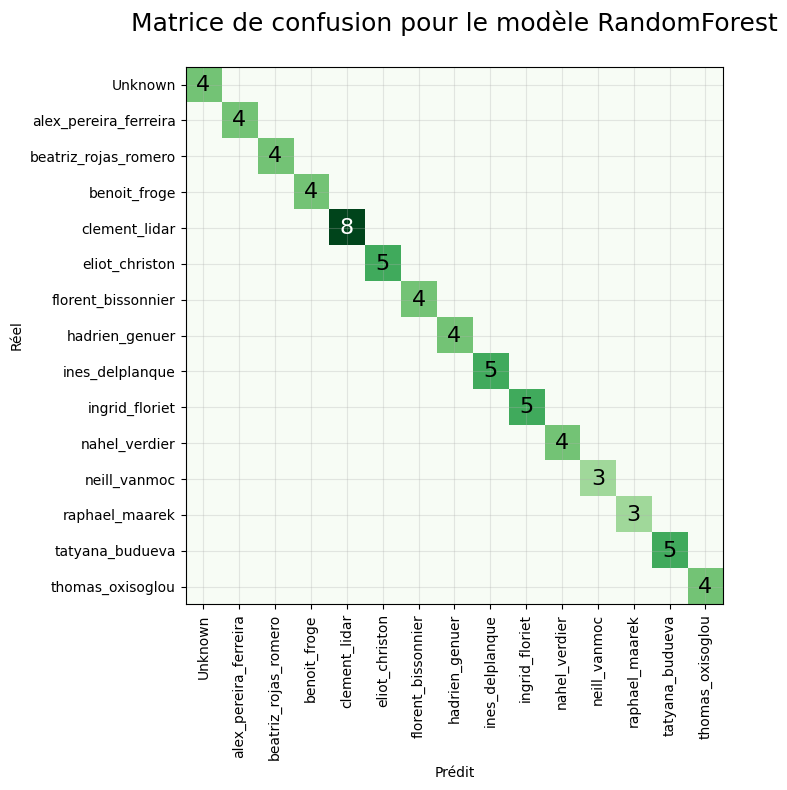

['../../../data/pretrained_models/person_recognition/speaker_verification_model.pkl']

In [70]:
def get_confusion_matrix(y_true, y_pred, labels):
    confusion_matrix = np.zeros((len(labels), len(labels)), dtype=int)
    for i, true_label in enumerate(labels):
        for j, pred_label in enumerate(labels):
            confusion_matrix[i, j] = np.sum((y_true == true_label) & (y_pred == pred_label))
    return confusion_matrix


# train the model with the best parameters
X_train, X_test, y_train, y_test = train_test_split_custom(X, y, N_unknown_in_training_data=best_params_according_to_scores['N_unknown_in_training_data'])

labels = np.unique(y_train)
# sort the labels
labels = np.sort(labels)

# create param_clf without N_unknown_in_training_data and threshold
param_clf = best_params_according_to_scores.copy()
del param_clf['N_unknown_in_training_data']
del param_clf['threshold']

clf = RandomForestClassifier(random_state=42, **param_clf)
clf.fit(X_train, y_train)

y_proba = clf.predict_proba(X_test)
y_pred = np.array([predict_with_rejection(proba, threshold=best_params_according_to_scores['threshold']) for proba in y_proba])

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nBEST MODEL SCORES")
print(f"  * Accuracy: {accuracy:.3f}")
print(f"  * Precision: {precision:.3f}")
print(f"  * Recall: {recall:.3f}")
print(f"  * F1: {f1:.3f}")

confusion_matrix = get_confusion_matrix(y_test, y_pred, labels)

plot_matrix(confusion_matrix, "RandomForest", labels, colormap=plt.colormaps.get('Greens'), N=0)

# save the classifier
import joblib
joblib.dump(clf, input_model_dir + "person_recognition/speaker_verification_model.pkl")


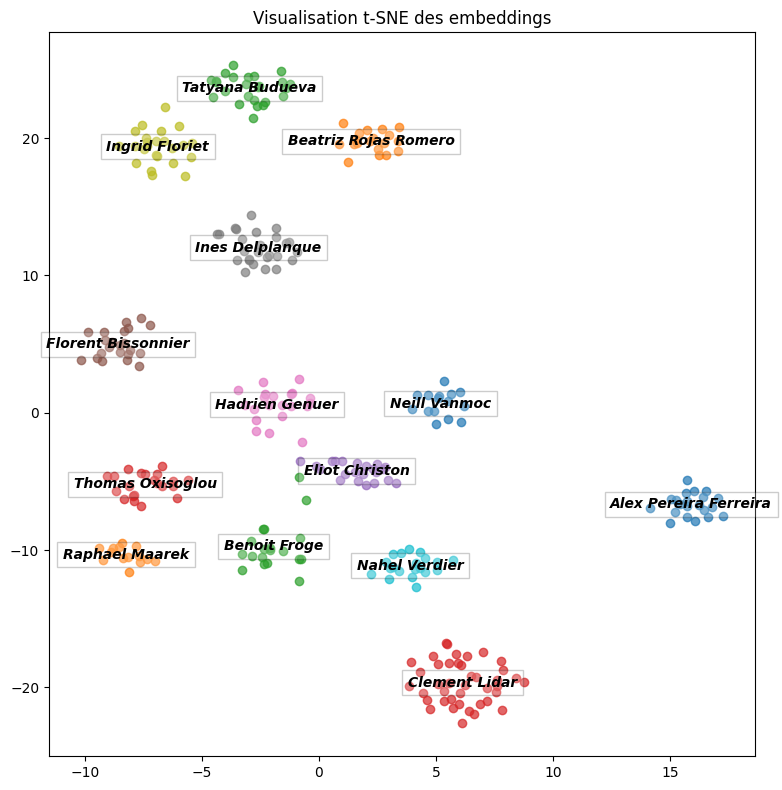

In [67]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

tsne = TSNE(n_components=2, random_state=42)
# remove Unknown from the embeddings
mask = y != "Unknown"
X_known = X[mask]
y_known = y[mask]
X_tsne = tsne.fit_transform(X_known)

# plot the t-SNE
fig, ax = plt.subplots(figsize=(8, 8))

for name in np.unique(y_known):

    mask = y_known == name
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], alpha=0.7)

    # put the name of the person at the mean of the embeddings (bold and italic font)
    x_mean = X_tsne[mask, 0].mean()
    y_mean = X_tsne[mask, 1].mean()
    name_str = " ".join(name.split("_")).title()
    # add transparent background to the text
    ax.text(x_mean, y_mean, name_str, horizontalalignment='center', verticalalignment='center', fontsize=10, fontstyle='italic', fontweight='bold', bbox=dict(facecolor='white', alpha=0.2))


if FRENCH:
    ax.set_title("Visualisation t-SNE des embeddings")
else:
    ax.set_title("t-SNE visualization of the embeddings")
plt.tight_layout()
plt.savefig("plots/tsne.png")
plt.show()


## Trying the full pipeline from both models

In [10]:
from speechbrain.inference.encoders import MelSpectrogramEncoder
import joblib
import time
import librosa
import torchaudio
from torch import Tensor
import numpy as np

input_model_dir = "../../../data/pretrained_models/"

In [11]:
embedding_model = MelSpectrogramEncoder.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb-mel-spec", savedir=input_model_dir + "spkrec-ecapa-voxceleb-mel-spec")
clf = joblib.load(input_model_dir + "person_recognition/speaker_verification_model.pkl")

In [24]:
audio_path = "test.wav"# "../../../data/stored/people/clement_lidar/voices/clement_lidar.wav"
labels = clf.classes_
print(labels)
def predict_with_rejection(proba, threshold=0.2):
    """predict with a threshold"""
    if proba.max() < threshold:
        return "Unknown"
    return labels[np.argmax(proba)]

def preprocess_audio(audio:Tensor) -> Tensor:
    """Preprocess the audio"""
    audio_numpy = audio.squeeze().numpy()
    intervals = librosa.effects.split(audio_numpy, top_db=20)
    audio_numpy = np.concatenate([audio_numpy[start:end] for start, end in intervals])
    # suppress pick sound, equalize
    audio_numpy = librosa.effects.preemphasis(audio_numpy)
    # normalize
    audio_numpy = librosa.util.normalize(audio_numpy)
    return Tensor(audio_numpy).unsqueeze(0)

['Unknown' 'alex_pereira_ferreira' 'beatriz_rojas_romero' 'benoit_froge'
 'clement_lidar' 'eliot_christon' 'florent_bissonnier' 'hadrien_genuer'
 'ines_delplanque' 'ingrid_floriet' 'nahel_verdier' 'neill_vanmoc'
 'raphael_maarek' 'tatyana_budueva' 'thomas_oxisoglou']


In [25]:
t0 = time.time()
audio_tensor, sr = torchaudio.load(audio_path)
t1 = time.time()
if sr != 16000:
    audio_tensor = torchaudio.transforms.Resample(sr, 16000)(audio_tensor)
t2 = time.time()
if audio_tensor.shape[0] == 2:
    audio_tensor = audio_tensor.mean(dim=0, keepdim=True)
t3 = time.time()
audio_tensor = preprocess_audio(audio_tensor)
t4 = time.time()
embedding = embedding_model.encode_waveform(audio_tensor)
embedding = embedding.detach().numpy().reshape(1, -1)
t4 = time.time()
y_proba = clf.predict_proba(embedding)
t5 = time.time()
y_pred = predict_with_rejection(y_proba[0], threshold=0.17)
t6 = time.time()

print(f"Time to load the audio        : {t1 - t0:.6f} s")
print(f"Time to resample the audio    : {t2 - t1:.6f} s")
print(f"Time to convert to mono       : {t3 - t2:.6f} s")
print(f"Time to preprocess the audio  : {t4 - t3:.6f} s")
print(f"Time to get the embedding     : {t5 - t4:.6f} s")
print(f"Time to predict               : {t6 - t5:.6f} s")
print(f"__________________________________________")
print(f"Total                           {t6 - t0:.6f} s")

print(f"\nPrediction: {y_pred}")

Time to load the audio        : 0.001252 s
Time to resample the audio    : 0.010435 s
Time to convert to mono       : 0.000000 s
Time to preprocess the audio  : 0.066216 s
Time to get the embedding     : 0.012490 s
Time to predict               : 0.000000 s
__________________________________________
Total                           0.090394 s

Prediction: eliot_christon
